In [15]:
# Author: Uzodimma E. Igodo 
# Date: 2023-07-14
# Description: This code implements a neural network built using a low level tool for linear algebra (numpy) 

# utilize tools for low level operations (linear algebra)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import three datasets to demonstrate image processing (and mutli-classification), binary classification, linear regresion respectively
from sklearn.datasets import load_digits, load_breast_cancer, fetch_california_housing, load_wine

In [16]:
# define a model class
class Model:
    def __init__(self, layers, input, target, loss_func):
        # store details of each layer in the 'layers' list
        # pad input data to enable vectorization of computations
        # 'loss_func' string notifies for either regression or classification
        # instantiate a dictonary to store training log values
        # since OVR multiclass technique is used, instantiate weights for each label 
        
        self.layers = layers
        num_features = input.shape[0]
        self.M = input.shape[1]
        self._input = input #unpadded input data will be required for model evaluation 
        pad_input = np.ones((1, self.M), dtype = np.float32)
        self.input = np.concatenate((self._input, pad_input), axis = 0)
        self.target = target
        self.loss_func = loss_func
        self.history = dict()
        if loss_func == 'crossentropy':
            self.classes = np.unique(target) # unique labels
            self.weights = [[None for i in range(len(layers))] for i in range(len(np.unique(target)))]
        elif loss_func == 'mean_square_error':
            self.weights = [None for i in range(len(layers))]
        
        
    def _forward_propagation(self, weight):
        # This method executes a forward pass of the train input data through the network
        # it returns an output and a list of cached data from each layer
        # cached data contains layer weights, input data, logits and type of activation fucntion used
        
        x = self.input
        CACHE = []
        for idx, layer in enumerate(self.layers):
            w = weight[idx]
            output, cache = layer._call(x, w)
            CACHE.append(cache)
            x = output
        return x, CACHE
    
    
    def Cost(self, input, target):
        # takes in input and output data and return the loss value
        # Defines the optimization objective of the model, which is to DECREASE the loss value
        # classfiication tasks use 'crossentropy loss' while linear regression tasks use 'MSE'. 
        # Both functions are suitable becuase they are DIFFERENTIABLE' 
        
        if self.loss_func == 'crossentropy':
            labels = self.classes
            num_labels = len(labels)
            _, proba = self.predict(input)
            true_label_one_hot = one_hot(target, num_labels)
            loss = crossentropy(proba.T, true_label_one_hot)
            return np.round(loss, 3)
        elif self.loss_func == 'mean_square_error':
            y_pred = self.predict(input)
            error = y_pred - target
            square_error = (error) ** 2
            mse = np.mean(square_error)
            return np.round(mse, 3)
    
    def Metric(self, input, target):
        # A second model performance metric to monitor model performance during training
        # classification uses 'accuracy score' while linear regression uses 'mean absolute error'
        
        if self.loss_func == 'crossentropy':
            y_pred,_ = self.predict(input)
            return np.round(accuracy(target, y_pred),3)
        elif self.loss_func == 'mean_square_error':
            y_pred = self.predict(input)
            error = y_pred - target
            abs_error = np.abs(error)
            mae = np.mean(abs_error)
            return np.round(mae, 3)
    
    
    def _back_propagation(self, true_target, pred_target, CACHE):
        # This method obtains the weight gradients for all layers using gradient descent algorithms and back propagation
        # inputs include, true labels and predicted labels, and cached data during forward propagation
        # returns the gradients of all layer weights 
        
        N = self.target.shape[1]
        CACHE = CACHE[::-1]
        cache_size = len(CACHE)
        DA = []
        weight_grads = []
        bias_grads = []
        
        idx = 0
        while idx <= cache_size - 1:
            if idx == 0:
                cache = CACHE[idx]
                z, w, a, f = cache
                dz = pred_target[:-1] - true_target
                if self.loss_func == 'crossentropy':
                    dw = (1/N) * (dz @ a.T)
                elif self.loss_func == 'mean_square_error':
                    dw = (1/N) * 2 * (dz @ a.T)
                da = w.T @ dz
                da = da[:-1]
                DA.append(da)
                weight_grads.append(dw)
            else:
                cache = CACHE[idx]
                z, w, a, f = cache
                if f == 'relu':
                    da = DA[idx - 1] * relu_derivative(z)
                elif f == 'sigmoid':
                    da = DA[idx - 1] * sigmoid_derivative(z)
                dw = (1/N) * (da @ a.T)
                da = w.T @ da
                da = da[:-1]
                DA.append(da)
                weight_grads.append(dw)
            idx += 1
            
        return weight_grads[::-1] #reverse list to ensure that output weights are last and and input weights are first
    
    
    def predict(self, input):
        # This generates a prediction 
        # returns discrete prediction values and prediction probabilites in classifiction tasks
        # returns continous values in linear regression task
        
        assert len(input.shape) == 2
        M = input.shape[1]
        pad = np.ones((1, M), dtype = np.float32)
        input = np.concatenate((input, pad), axis = 0)
        if self.loss_func == 'crossentropy':
            outputs = []
            for w in (self.weights):
                x = input
                for idx, layer in enumerate(self.layers):
                    w_ = w[idx]
                    output, _ = layer._call(x, w_)
                    x = output
                outputs.append(output[:-1])
            label = np.array(outputs).argmax(axis = 0) # index of the highest probability is the prediction
            return label, np.squeeze(outputs)
        elif self.loss_func == 'mean_square_error':
            x = input
            for idx, layer in enumerate(self.layers):
                w_ = self.weights[idx]
                output, _ = layer._call(x, w_)
                x = output
            return output[:-1] # strip out 'ones' padding to obtain output

    def train(self, input_val, target_val, learning_rate = 0.01, epochs = 20):
        # method to implement forward propagation, then backward propagation, then weight update
        # print loss and metric values after each epoch using the updated weights to monitor model performance
        # transfer loss and metric values per epoch to 'self.history' dictionary
        
        num_layers = len(self.layers)
        lr = learning_rate
        cost_list = []
        train_metrics = []
        val_cost_list = []
        val_metrics = []
        
        for i in range(epochs):
            if self.loss_func == 'crossentropy':
                for idx, label in enumerate(self.classes):
                    one_hot_target = (self.target == label).astype(np.float32)
                    pred_target, CACHE = self._forward_propagation(self.weights[idx])
                    weights = [cache[1] for cache in CACHE]
                    weight_grads = self._back_propagation(one_hot_target, pred_target, CACHE)
                    
                    temp_weights = [W - (lr * dW) for W,dW in zip(weights, weight_grads)] # update weights of every layer
                    self.weights[idx] = temp_weights  
            elif self.loss_func == 'mean_square_error':
                true_target = self.target
                pred_target, CACHE = self._forward_propagation(self.weights)
                weights = [cache[1] for cache in CACHE]
                weight_grads = self._back_propagation(true_target, pred_target, CACHE)
                
                temp_weights = [W - (lr * dW) for W,dW in zip(weights, weight_grads)] # update weights of every layer
                self.weights = temp_weights
                
            cost = self.Cost(self._input, self.target)
            metric = self.Metric(self._input, self.target)
            cost_list.append(cost)
            train_metrics.append(metric)
            
            val_cost = self.Cost(input_val, target_val)
            val_metric = self.Metric(input_val, target_val)
            val_cost_list.append(val_cost)
            val_metrics.append(val_metric)
            
            print(f'Epoch--{i+1}---Train_Loss-{cost}----Train_Metric--{metric}-|-Val_Loss--{val_cost}----Val_Metric--{val_metric}')
                
        self.history['Train_Loss'] = cost_list
        self.history['Val_Loss'] = val_cost_list
        self.history['Train_Metric'] = train_metrics
        self.history['Val_Metric'] = val_metrics
    


In [17]:
class Layer(Model):
    # This class inherits from the 'Model' class
    # Class to enable users to customize model architecture by defining depth of network, number of nodes per layer and activation fucntions
    
    def __init__(self, nodes, activation_function = None):
        self.nodes = nodes
        self.activation_function = activation_function
        
    def _call(self, input, weight):
        # method to execute a simple linear computation of logits from weights and inputs (y = mx + b)
        # and implementation of non-linearity using either 'sigmoid' or 'relu' activation functions
        # method outputs include layer activations and necessary data cached for backpropagation
        
        if (weight is None):
            features = input.shape[0]
            np.random.seed(0)
            weight = np.random.randn(self.nodes, features) * np.sqrt(2/features) # initialize weights using 'He initilaization'
        
        logit = weight @ input
        if self.activation_function == 'sigmoid':
            activation = sigmoid(logit)
        elif self.activation_function == 'relu':
            activation = relu(logit)
        else:
            activation = logit
        M = activation.shape[1]
        pad = np.ones((1, M), dtype = np.float32)
        activation = np.concatenate((activation, pad), axis = 0)
        function = self.activation_function
        cache = [logit, weight, input, function] 
        return activation, cache
    
                
        

In [18]:
# utility functions to be used at different points during implemntation of the model

def sigmoid(logit):
    return np.where(logit >= 0, 1/(1 + np.exp(-1 * logit)), np.exp(logit)/(1 + np.exp(logit)))

def sigmoid_derivative(logit):
    return sigmoid(logit) * (1 - sigmoid(logit))

def relu(logit):
    return np.maximum(0.0, logit)

def relu_derivative(logit):
    # Clip values to avoid numerical instability
    logit_clipped = np.clip(logit, -1e10, 1e10)
    derivative = np.where(logit_clipped > 0, 1, 0)
    return derivative

def crossentropy(y_true, y_pred_proba):
    epsilon = 1e-7  # Small value to prevent division by zero
    # Clip values to avoid numerical instability
    y_pred_proba = np.clip(y_pred_proba, epsilon, 1 - epsilon)
    loss = np.mean(-(y_true * np.log(y_pred_proba) + (1 - y_true) * np.log(1 - y_pred_proba)))
    return loss

def one_hot(target, num_classes):
    return np.squeeze(np.eye(num_classes)[target])

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

# function to split data into train, validation and test sets
def split_index(num_rows, val_size = 0.20, test_size = 0.05, seed = 100):
    np.random.seed(seed)
    test_slice = int(num_rows * test_size)
    val_slice = int(num_rows * val_size)
    train_slice = int(num_rows * (1 - val_size + test_slice))
    index_array = np.arange(num_rows)
    np.random.shuffle(index_array)
    test_idx = index_array[ : test_slice]
    val_idx = index_array[test_slice : val_slice]
    train_idx = index_array[val_slice : train_slice]
    return train_idx, val_idx, test_idx

def display_images(data, label, num):
    fig, ax = plt.subplots(1, num)
    for i in range(num):
        idx = np.random.choice(data.shape[1])
        ax[i].imshow(data[:,idx].reshape(8,8))
        ax[i].set_title(label[0, idx])
        ax[i].set_axis_off()

def plot_learning_curves(log):
    fig, ax = plt.subplots(2,1, sharex = True, figsize = (5,10))
    ax[0].plot(log.index, log.iloc[:,0], label = 'Train')
    ax[0].plot(log.index, log.iloc[:,1], label = 'Val')
    ax[1].plot(log.index, log.iloc[:,2], label = 'Train')
    ax[1].plot(log.index, log.iloc[:,3], label = 'Val')
    ax[0].set_title(f'{log.columns[0]} vs {log.columns[1]}')
    ax[1].set_title(f'{log.columns[2]} vs {log.columns[3]}')
    ax[0].set_ylabel('Loss')
    ax[1].set_ylabel('Metric')
    ax[1].set_xlabel('Epochs')
    ax[0].legend()
    ax[1].legend()
    plt.show() 

**DEEP LEARNING MODEL FOR MULTICLASS CLASSIFICATION**

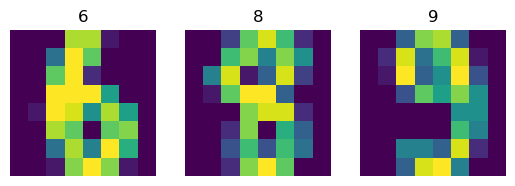

In [19]:
# load the mnist hand written digits recognition dataset
# scale and split and shuffle the dataset
data = load_digits()
input = pd.DataFrame(data = data.data).values.reshape(-1, 64)/16
target = pd.Series(data = data.target).values.reshape(-1,1)
num_examples = input.shape[0]
train_idx, val_idx, test_idx = split_index(num_examples)

train_input, train_output = input[train_idx,:].T, target[train_idx,:].T # datasets should be of (features * examples) orientation
val_input, val_output = input[val_idx,:].T, target[val_idx,:].T
test_input, test_output = input[test_idx,:].T, target[test_idx,:].T

#view samples of digit images and their labels
display_images(test_input, test_output, 3)

Initial Test Crossentropy loss is 8.92 and Initial Test Prediction accuracy is 6.7 percent


......Training has commenced.......
Epoch--1---Train_Loss-7.744----Train_Metric--0.232-|-Val_Loss--7.742----Val_Metric--0.259
Epoch--2---Train_Loss-7.615----Train_Metric--0.22-|-Val_Loss--7.612----Val_Metric--0.23
Epoch--3---Train_Loss-7.488----Train_Metric--0.204-|-Val_Loss--7.484----Val_Metric--0.237
Epoch--4---Train_Loss-7.358----Train_Metric--0.198-|-Val_Loss--7.353----Val_Metric--0.215
Epoch--5---Train_Loss-7.217----Train_Metric--0.184-|-Val_Loss--7.21----Val_Metric--0.196
Epoch--6---Train_Loss-7.047----Train_Metric--0.15-|-Val_Loss--7.04----Val_Metric--0.167
Epoch--7---Train_Loss-6.821----Train_Metric--0.135-|-Val_Loss--6.818----Val_Metric--0.148
Epoch--8---Train_Loss-6.44----Train_Metric--0.151-|-Val_Loss--6.433----Val_Metric--0.148
Epoch--9---Train_Loss-5.57----Train_Metric--0.106-|-Val_Loss--5.565----Val_Metric--0.085
Epoch--10---Train_Loss-4.742----Train_Metric--0.102-|-Val_Loss--4.74

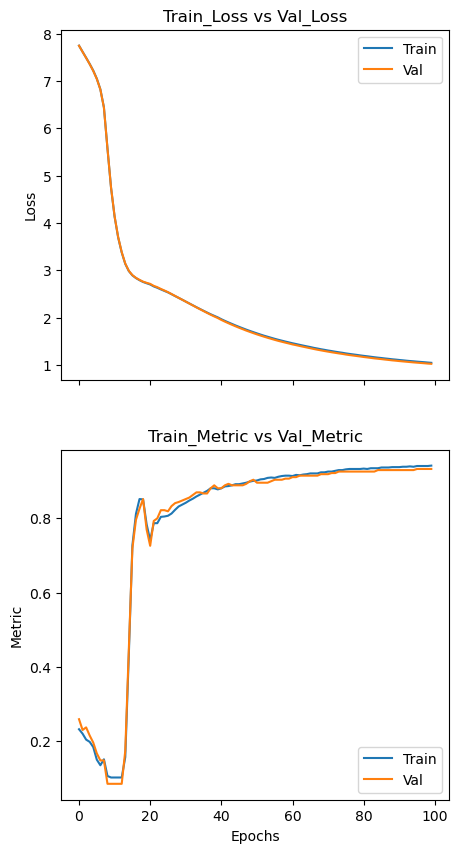



Final Test Crossentropy loss is 1.068 and Final Test Prediction accuracy is 91.0 percent
-----NB: The Accuracy is expected to INCREASE after training-----


...predicting a randomly selected test sample...
True label of the random sample is 6 and its predicted label is 6


In [20]:
# build model architecture by staking layers into a list
# from left to write the first element of the list is the input layer and the last element is the output layer
layers =  [Layer(512, 'relu'), Layer(8, 'relu'), Layer(1, 'sigmoid')]

# create model instance, since task is classification loss function is cross entropy
model = Model(layers, train_input, train_output, loss_func = 'crossentropy')

# display performance on test set before model training
print(f'Initial Test Crossentropy loss is {model.Cost(test_input, test_output)} and Initial Test Prediction accuracy is {model.Metric(test_input, test_output) * 100} percent')
print('\n')

# train model for 100 epochs
print('......Training has commenced.......')
model.train(val_input, val_output, learning_rate = 0.1, epochs = 100)
print('......Training has ended......')
print('\n')

# load the training log details into a pandas dataframe
#plot the train loss vs val loss and train accuracy vs val accuracy
log = pd.DataFrame(model.history)
plot_learning_curves(log)
print('\n')

# display performance on test set after model training
print(f'Final Test Crossentropy loss is {model.Cost(test_input, test_output)} and Final Test Prediction accuracy is {model.Metric(test_input, test_output) * 100} percent')
print('-----NB: The Accuracy is expected to INCREASE after training-----')
print('\n')

# make some predcitons with the model
idx = np.random.choice(test_input.shape[1])
predicted_label, _  = model.predict(test_input[:, idx].reshape(-1,1))
predicted_label = np.squeeze(predicted_label)
true_label = test_output[:, idx][0]
print('...predicting a randomly selected test sample...')
print(f'True label of the random sample is {true_label} and its predicted label is {predicted_label}')


**DEEP LEARNING MODEL FOR BINARY CLASSIFICATION**

Initial Test Crossentropy loss is 8.059 and Initial Test Prediction accuracy is 50.0 percent


......Training has commenced.......
Epoch--1---Train_Loss-4.291----Train_Metric--0.914-|-Val_Loss--4.055----Val_Metric--0.941
Epoch--2---Train_Loss-3.281----Train_Metric--0.943-|-Val_Loss--2.912----Val_Metric--0.965
Epoch--3---Train_Loss-2.743----Train_Metric--0.956-|-Val_Loss--2.373----Val_Metric--0.965
Epoch--4---Train_Loss-2.383----Train_Metric--0.958-|-Val_Loss--2.026----Val_Metric--0.965
Epoch--5---Train_Loss-2.119----Train_Metric--0.965-|-Val_Loss--1.783----Val_Metric--0.965
Epoch--6---Train_Loss-1.918----Train_Metric--0.967-|-Val_Loss--1.604----Val_Metric--0.965
Epoch--7---Train_Loss-1.759----Train_Metric--0.967-|-Val_Loss--1.466----Val_Metric--0.965
Epoch--8---Train_Loss-1.632----Train_Metric--0.969-|-Val_Loss--1.357----Val_Metric--0.976
Epoch--9---Train_Loss-1.527----Train_Metric--0.969-|-Val_Loss--1.269----Val_Metric--0.976
Epoch--10---Train_Loss-1.438----Train_Metric--0.974-|-Val_L

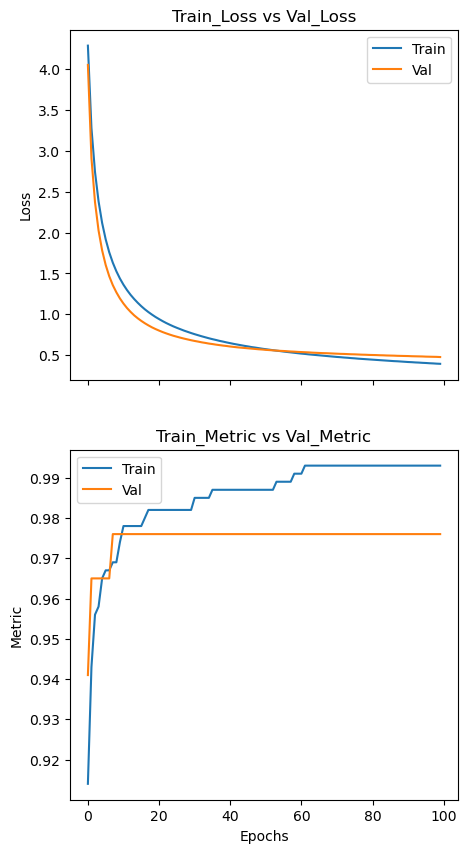



Final Test Crossentropy loss is 1.356 and Final Test Prediction accuracy is 92.9 percent
-----NB: Accuracy is expected to INCREASE after training-----


...predicting a randomly selected test sample...
True label of the random sample is 1 and its predicted label is 1


In [21]:
# load the breast cancer binary classification dataset
# scale and split and shuffle the dataset

data2 = load_breast_cancer()
input2 = pd.DataFrame(data = data2.data).values
input2 = (input2 - input2.mean(axis = 0))/input2.std(axis = 0) #normalize and scale the dataset
target2 = pd.Series(data = data2.target).values.reshape(-1,1)
num_examples2 = input2.shape[0]
train_idx2, val_idx2, test_idx2 = split_index(num_examples2)

train_input2, train_output2 = input2[train_idx2,:].T, target2[train_idx2,:].T
val_input2, val_output2 = input2[val_idx2,:].T, target2[val_idx2,:].T
test_input2, test_output2 = input2[test_idx2,:].T, target2[test_idx2,:].T

# build model architecture by staking layers into a list
# from left to write the first element of the list is the input layer and the last element is the output layer
layers2 =  [Layer(216, 'relu'), Layer(128, 'relu'), Layer(64, 'relu'), Layer(1, 'sigmoid')]

# create model instance, since task is classification loss function is cross entropy
model2 = Model(layers2, train_input2, train_output2, loss_func = 'crossentropy')

# display performance on test set before model training
print(f'Initial Test Crossentropy loss is {model2.Cost(test_input2, test_output2)} and Initial Test Prediction accuracy is {model2.Metric(test_input2, test_output2) * 100} percent')
print('\n')

# train model for 100 epochs
print('......Training has commenced.......')
model2.train(val_input2, val_output2, learning_rate = 0.1, epochs = 100)
print('......Training has ended......')
print('\n')

# load the training log details into a pandas dataframe
#plot the train loss vs val loss and train accuracy vs val accuracy
log2 = pd.DataFrame(model2.history)
plot_learning_curves(log2)
print('\n')

# display performance on test set after model training
print(f'Final Test Crossentropy loss is {model2.Cost(test_input2, test_output2)} and Final Test Prediction accuracy is {model2.Metric(test_input2, test_output2) * 100} percent')
print('-----NB: Accuracy is expected to INCREASE after training-----')
print('\n')

# make some predcitons with the model
idx = np.random.choice(test_input2.shape[1])
predicted_label2, _  = model2.predict(test_input2[:, idx].reshape(-1,1))
predicted_label2 = np.squeeze(predicted_label2)
true_label2 = test_output2[:, idx][0]
print('...predicting a randomly selected test sample...')
print(f'True label of the random sample is {true_label2} and its predicted label is {predicted_label2}')


**DEEP LEARNING MODEL FOR LINEAR REGRESSION**

Initial Test Mean squared error loss is 23.92 and Initial Test Mean absolute error is 2.986


......Training has commenced.......
Epoch--1---Train_Loss-7.13----Train_Metric--2.289-|-Val_Loss--7.027----Val_Metric--2.282
Epoch--2---Train_Loss-2.582----Train_Metric--1.203-|-Val_Loss--2.495----Val_Metric--1.185
Epoch--3---Train_Loss-2.006----Train_Metric--1.012-|-Val_Loss--1.922----Val_Metric--0.992
Epoch--4---Train_Loss-1.7----Train_Metric--0.921-|-Val_Loss--1.62----Val_Metric--0.9
Epoch--5---Train_Loss-1.522----Train_Metric--0.875-|-Val_Loss--1.446----Val_Metric--0.855
Epoch--6---Train_Loss-1.414----Train_Metric--0.854-|-Val_Loss--1.341----Val_Metric--0.834
Epoch--7---Train_Loss-1.346----Train_Metric--0.845-|-Val_Loss--1.275----Val_Metric--0.827
Epoch--8---Train_Loss-1.301----Train_Metric--0.842-|-Val_Loss--1.233----Val_Metric--0.824
Epoch--9---Train_Loss-1.27----Train_Metric--0.841-|-Val_Loss--1.205----Val_Metric--0.824
Epoch--10---Train_Loss-1.248----Train_Metric--0.841-|-Val_Loss--1.1

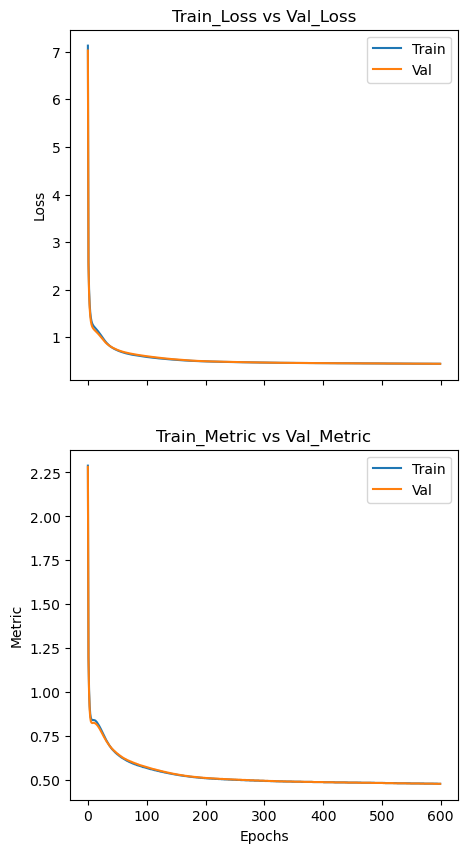



Final Test Mean squared error loss is 0.45 and Final Test Mean absolute error is 0.485
-----NB: The Mean Absolute Error is expected to DECREASE after training-----


...predicting price of a randomly selected house...
True price of the random house is 3.352 and its predicted price is 4.07


In [22]:
# load the california house price dataset
# scale and split and shuffle the dataset

data3 = fetch_california_housing()
input3 = pd.DataFrame(data = data3.data).values
input3 = (input3 - input3.mean(axis = 0))/input3.std(axis = 0) #normalize and scale the dataset
target3 = pd.Series(data = data3.target).values.reshape(-1,1)
num_examples3 = input3.shape[0]
train_idx3, val_idx3, test_idx3 = split_index(num_examples3, seed = 0)

train_input3, train_output3 = input3[train_idx3,:].T, target3[train_idx3,:].T
val_input3, val_output3 = input3[val_idx3,:].T, target3[val_idx3,:].T
test_input3, test_output3 = input3[test_idx3,:].T, target3[test_idx3,:].T

# build model architecture by staking layers into a list
# from left to write the first element of the list is the input layer and the last element is the output layer
layers3 =  [Layer(8, 'relu'), Layer(4, 'relu'), Layer(1)]

# create model instance, since task is classification loss function is cross entropy
model3 = Model(layers3, train_input3, train_output3, loss_func = 'mean_square_error')

# display performance on test set before model training
print(f'Initial Test Mean squared error loss is {model3.Cost(test_input3, test_output3)} and Initial Test Mean absolute error is {model3.Metric(test_input3, test_output3)}')
print('\n')

# train model for 100 epochs
print('......Training has commenced.......')
model3.train(val_input3, val_output3, learning_rate = 0.1, epochs = 600)
print('......Training has ended......')
print('\n')

# load the training log details into a pandas dataframe
#plot the train loss vs val loss and train accuracy vs val accuracy
log3 = pd.DataFrame(model3.history)
plot_learning_curves(log3)
print('\n')

# display performance on test set after model training
print(f'Final Test Mean squared error loss is {model3.Cost(test_input3, test_output3)} and Final Test Mean absolute error is {model3.Metric(test_input3, test_output3)}')
print('-----NB: The Mean Absolute Error is expected to DECREASE after training-----')
print('\n')

# make some predcitons with the model
idx = np.random.choice(test_input3.shape[1])
predicted_label3 = model3.predict(test_input3[:, idx].reshape(-1,1))
predicted_label3 = np.round(np.squeeze(predicted_label3), 3)
true_label3 = test_output3[:, idx][0]
print('...predicting price of a randomly selected house...')
print(f'True price of the random house is {true_label3} and its predicted price is {predicted_label3}')
